#####   
<span style="font-family:Arial; font-weight:Bold; font-size:2.5em; color:#00b3e5;"> WaveNet - Stock Market Prediction

#####   
<span style="font-family:Arial; font-weight:Bold; font-size:2.3em; color:#00b3e5;"> Importing Libraries

In [1]:
import numpy  as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

import tensorflow       as   tf
from   tensorflow     import keras
from keras.models     import Sequential
from keras.layers     import LSTM, Dropout, Dense, Activation, SimpleRNN, TimeDistributed
from keras.optimizers import Adam
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

#####   
<span style="font-family:Arial; font-weight:Bold; font-size:2.3em; color:#00b3e5;"> Importing Data

In [2]:
Project_Name = 'Google_Stock_Price'

data = pd.read_csv('Google_Stock_Price.csv')
data.head(3)

,Date,Open,High,Low,Close,Volume
0,1/3/2012,325.25,332.83,324.97,663.59,"7,380,500"
1,1/4/2012,331.27,333.87,329.08,666.45,"5,749,400"
2,1/5/2012,329.83,330.75,326.89,657.21,"6,590,300"


In [3]:
C = data[['Open']].copy()
#for i in range(C.shape[0]):  C.loc[i,'Open'] = C.loc[i,'Open'].replace(",","") 

In [4]:
TimeSeries         = C.astype(float)
TimeSeries.index   = pd.to_datetime( data['Date'].values, format='%m/%d/%Y')
TimeSeries.columns =     ['Series']
TimeSeries.tail(3)

,Series
2016-12-28,793.70
2016-12-29,783.33
2016-12-30,782.75


#####   
<span style="font-family:Arial; font-weight:Bold; font-size:2.3em; color:#00b3e5;"> Smooting Series & Noisy Seasonality

In [5]:
''' 
def smoother( df, ft, n ):
    s = df[ft].values.copy()
    for i in range(n): 
        for i in np.arange( 2, TimeSeries.shape[0]-1, 2 ):
            s[i] = ( s[i-1]+s[i+1] ) / 2
        for i in np.arange( 1, TimeSeries.shape[0]-1, 2 ):
            s[i] = ( s[i-1]+s[i+1] ) / 2
    noise = df[ft].values.copy() - s
    return s, noise
''' 

def smoother( df, ft, n ):
    s = df[ft].values.copy()
    for i in range(n): 
        for i in np.arange( 2, df.shape[0]-1, 2 ):
            s[i] = ( s[i-1]+s[i+1] ) / 2
        for i in np.arange( 1, df.shape[0]-1, 2 ):
            s[i] = ( s[i-1]+s[i+1] ) / 2
    noise = df[ft].values.copy() - s
    return s, noise

smoothed, noise = smoother( TimeSeries, 'Series', 20 )

TimeSeries[     'Noise'     ] = np.round( noise, 0 )  
TimeSeries['Smoothed_Series'] = np.round( smoothed, 0 ) 
TimeSeries.tail(3)

,Series,Noise,Smoothed_Series
2016-12-28,793.70,9.0,785.0
2016-12-29,783.33,-0.0,784.0
2016-12-30,782.75,0.0,783.0


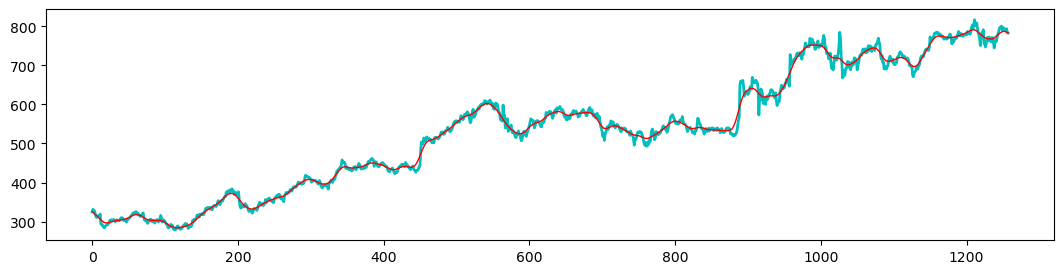

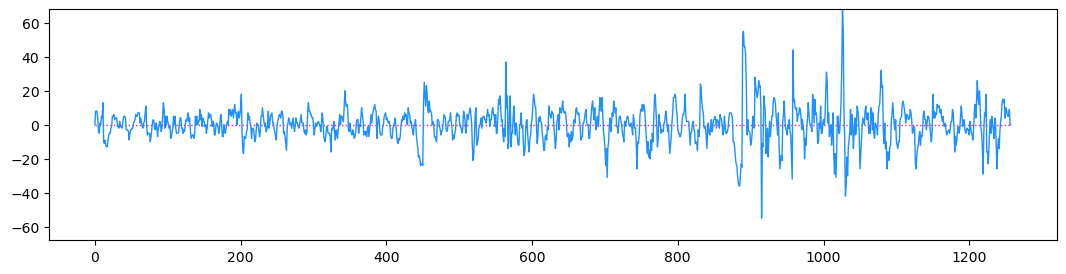

In [6]:
Range = range(TimeSeries.shape[0])
plt.figure(figsize=(13,3))
plt.plot(Range,TimeSeries['Series'],color='c',linewidth=2 ) 
plt.plot(Range,TimeSeries['Smoothed_Series'],color='r',linewidth=1) 
plt.show()

plt.figure(figsize=(13,3))
plt.plot( [Range[0],Range[-1]], [0,0], color='deeppink'  , linewidth=1, linestyle=':' )
plt.plot(  Range, TimeSeries['Noise'], color='dodgerblue', linewidth=1                ) 
mx=max(abs(TimeSeries['Noise']));plt.gca().set_ylim(-mx,+mx)
plt.show()

#####   
<span style="font-family:Arial; font-weight:Bold; font-size:2.3em; color:#00b3e5;"> Trend & Initial_Value & Residuals

C:\ProgramData\anaconda3\lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
C:\ProgramData\anaconda3\lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\ProgramData\anaconda3\lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\ProgramData\anaconda3\lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  i

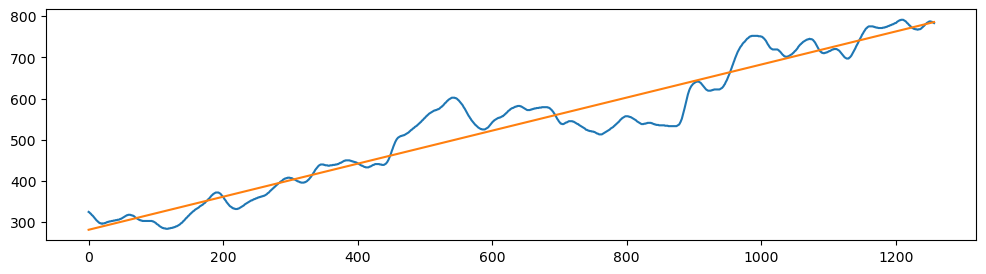

In [7]:
# Tend  
import numpy as np
from sklearn.linear_model import LinearRegression

T = pd.DataFrame( range( TimeSeries[ 'Smoothed_Series' ].shape[0] ))  
model = LinearRegression().fit( T, TimeSeries[['Smoothed_Series']] ) 

# trnd & initial values
trend         = model.coef_[0]     # slope
initial_value = model.intercept_   # intercept

# Trend
trend_line = trend*T + initial_value
TimeSeries['Trend'] = trend_line.values

# Plot
plt.figure(figsize=(12,3))
plt.plot( T, TimeSeries[['Smoothed_Series']] )
plt.plot( T, TimeSeries['Trend'] )
plt.show()

In [8]:
#residual = y.values - trend_line.values
TimeSeries['Cyclic_Seasonality'] = TimeSeries['Smoothed_Series'] - TimeSeries['Trend']
TimeSeries.tail(3)

,Series,Noise,Smoothed_Series,Trend,Cyclic_Seasonality
2016-12-28,793.70,9.0,785.0,784.708777,0.291223
2016-12-29,783.33,-0.0,784.0,785.109633,-1.109633
2016-12-30,782.75,0.0,783.0,785.510489,-2.510489


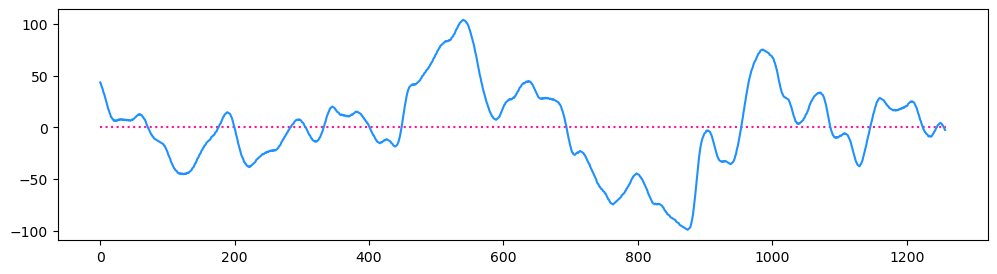

In [9]:
plt.figure( figsize=(12,3) )
plt.plot( [0,len(T)], [0,0], ':', color='deeppink' )
plt.plot( T, TimeSeries['Cyclic_Seasonality'], color='dodgerblue' )
plt.show()

#####   
<span style="font-family:Arial; font-weight:Bold; font-size:2.3em; color:#00b3e5;"> Cyclicity

In [10]:
res = TimeSeries['Cyclic_Seasonality'].values

# The Function To Be Minimized 
def obj_func(p):   
    A, w, lag  = p  
    sig = []
    for t in range(TimeSeries.shape[0]):
        sig.append( A * np.sin( w*t + lag )  )
    SE = [ (i-j)**2 for i,j in zip(res,sig) ]
    return ( sum(SE)/len(SE) ) ** 0.5

from sko.GA import GA
ga = GA( func      = obj_func
       , n_dim     = 3
       , size_pop  = 200 
       , max_iter  = 100 
       , ub        = [2*np.max(res), 2*np.pi, 2*np.pi]
       , lb        = [   0.00001,    0.00001, 0.00001]
       , prob_mut  = 0.05
       , precision = 0.0001
       #, constraint_eq  = constraint_eq
       #, constraint_ueq = constraint_ueq
       )
Best_X, Best_y = ga.fit()
[Best_X, Best_y]

[array([40.55474826,  6.27244738,  0.81494221]), 29.228593851430368]

In [10]:
Best_X = [41.04504588,  6.2723515 ,  0.86719375]
Best_y = 29.2408

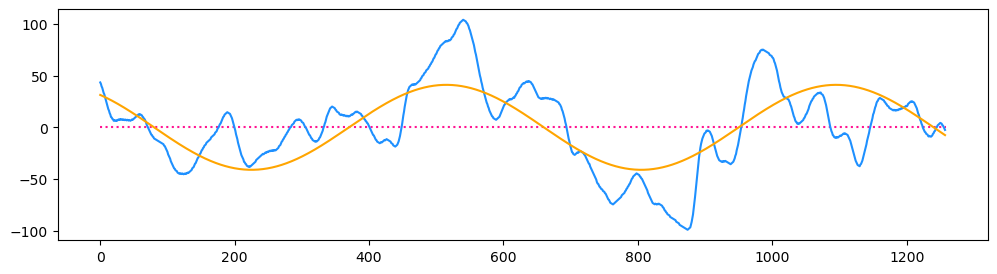

In [11]:
A, w, Lag = Best_X

res = TimeSeries['Cyclic_Seasonality'].values
T   = range( len(res) ) 
sig = [ A*np.sin(w*t+Lag) for t in T ]
    
plt.figure(figsize=(12,3))
plt.plot( [0,len(T)], [0,0], color='deeppink', linestyle=":" )
plt.plot(    T,        res , color='dodgerblue' )
plt.plot(    T,        sig , color='orange'     )
plt.show()

In [12]:
TimeSeries['Cyclicity'] = sig
TimeSeries.tail(3)

,Series,Noise,Smoothed_Series,Trend,Cyclic_Seasonality,Cyclicity
2016-12-28,793.70,9.0,785.0,784.708777,0.291223,-6.655233
2016-12-29,783.33,-0.0,784.0,785.109633,-1.109633,-7.093624
2016-12-30,782.75,0.0,783.0,785.510489,-2.510489,-7.531182


#####   
<span style="font-family:Arial; font-weight:Bold; font-size:2.3em; color:#00b3e5;"> Cyclic Trend

In [13]:
TimeSeries['Cyclic_Trend'] = TimeSeries['Trend']+TimeSeries['Cyclicity']
TimeSeries.tail(3)

,Series,Noise,Smoothed_Series,Trend,Cyclic_Seasonality,Cyclicity,Cyclic_Trend
2016-12-28,793.70,9.0,785.0,784.708777,0.291223,-6.655233,778.053543
2016-12-29,783.33,-0.0,784.0,785.109633,-1.109633,-7.093624,778.016009
2016-12-30,782.75,0.0,783.0,785.510489,-2.510489,-7.531182,777.979307


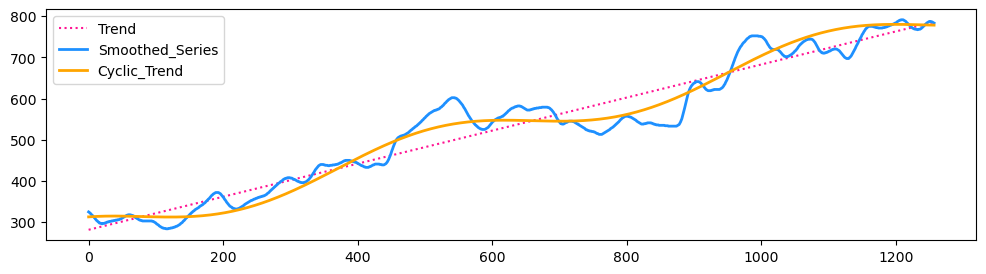

In [14]:
T = range( TimeSeries.shape[0] )
y1 = TimeSeries['Trend']
y2 = TimeSeries['Smoothed_Series']
y3 = TimeSeries['Cyclic_Trend']

plt.figure(figsize=(12,3))
plt.plot(T,y1,color='deeppink'  ,linestyle=':',label='Trend'          )
plt.plot(T,y2,color='dodgerblue',linewidth=2  ,label='Smoothed_Series')
plt.plot(T,y3,color='orange'    ,linewidth=2  ,label='Cyclic_Trend'   )
plt.legend()

#####   
<span style="font-family:Arial; font-weight:Bold; font-size:2.3em; color:#00b3e5;"> Cyclic Seasonality

<span style="font-family:Arial; font-weight:Bold; font-size:1.8em; color:#00b3e5;"> Extracting Y, M, D from Dates

In [15]:
Dates = TimeSeries.index.date.tolist()
Dates[:3]

[datetime.date(2012, 1, 3),
 datetime.date(2012, 1, 4),
 datetime.date(2012, 1, 5)]

In [16]:
Dates = pd.to_datetime(Dates, format='%m/%d/%Y')
Dates[:3]

DatetimeIndex(['2012-01-03', '2012-01-04', '2012-01-05'], dtype='datetime64[ns]', freq=None)

In [17]:
df = pd.DataFrame()
df['Year' ] = Dates.year
df['month'] = Dates.month
df[ 'day' ] = Dates.day
df.index = Dates
df.sample(3)

,Year,month,day
2013-04-29,2013,4,29
2015-09-28,2015,9,28
2015-07-01,2015,7,1


In [18]:
Seasons = pd.concat([df,TimeSeries],axis=1) 
Seasons.tail(3)

,Year,month,day,Series,Noise,Smoothed_Series,Trend,Cyclic_Seasonality,Cyclicity,Cyclic_Trend
2016-12-28,2016,12,28,793.70,9.0,785.0,784.708777,0.291223,-6.655233,778.053543
2016-12-29,2016,12,29,783.33,-0.0,784.0,785.109633,-1.109633,-7.093624,778.016009
2016-12-30,2016,12,30,782.75,0.0,783.0,785.510489,-2.510489,-7.531182,777.979307


<span style="font-family:Arial; font-weight:Bold; font-size:1.8em; color:#00b3e5;"> Visualizing Cyclic Seasonality

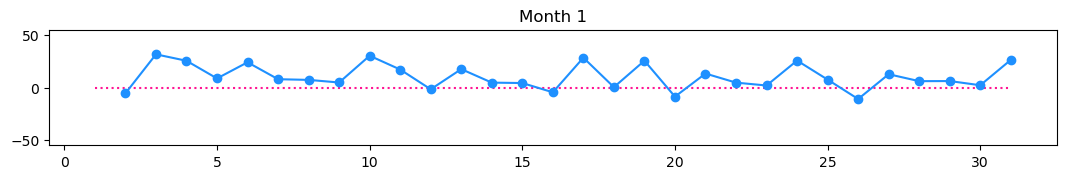

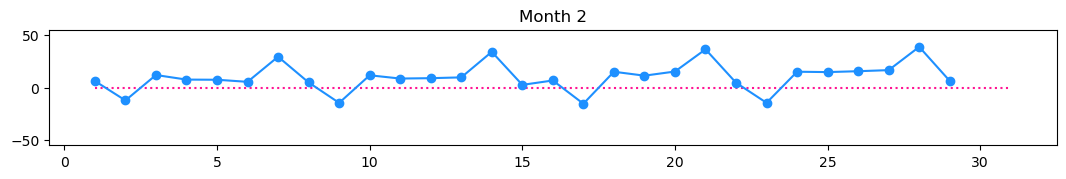

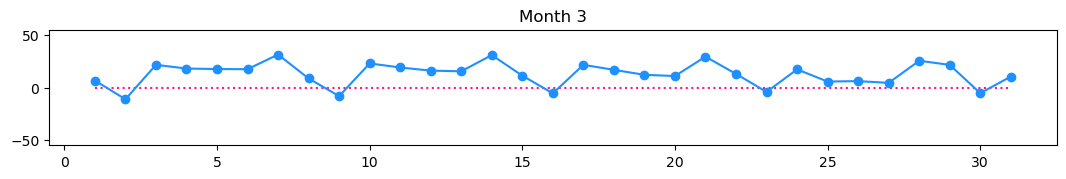

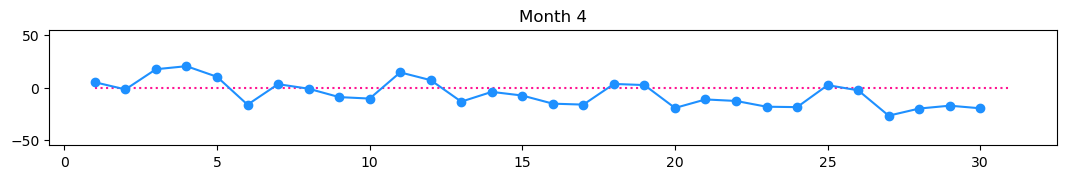

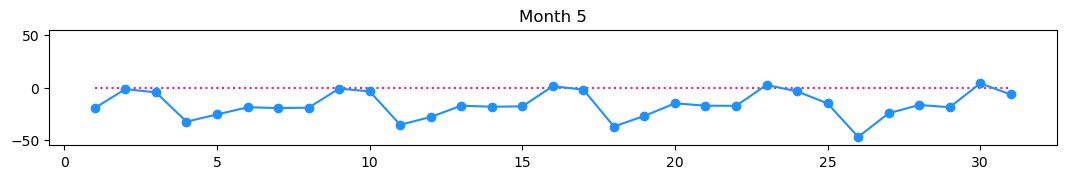

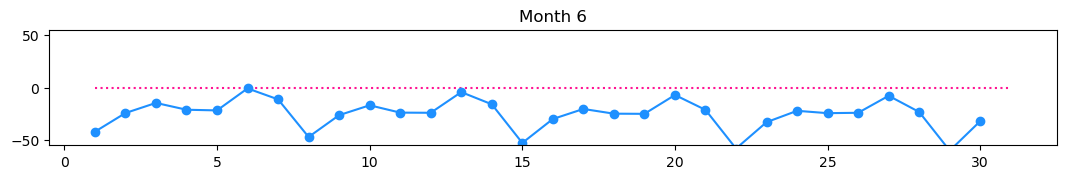

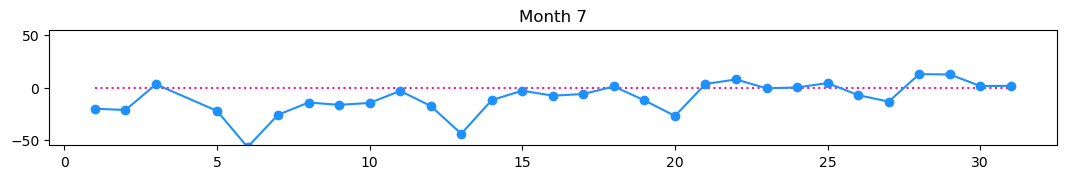

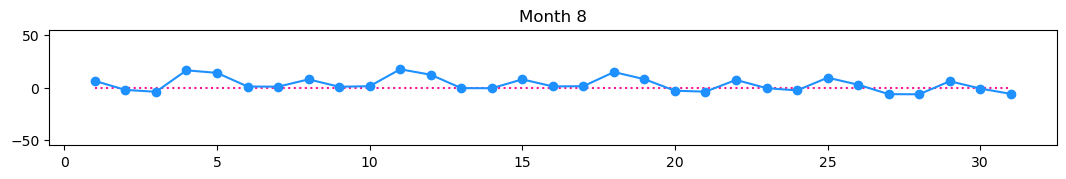

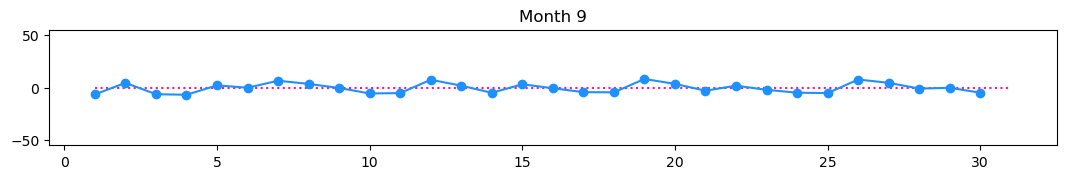

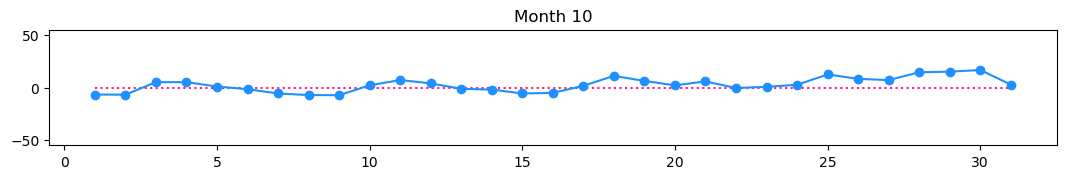

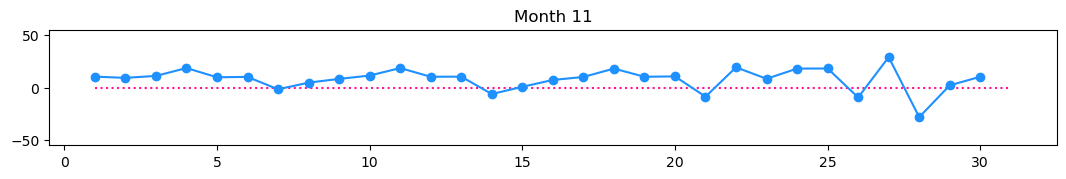

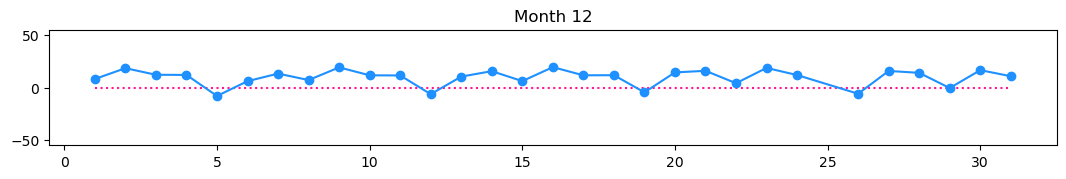

In [19]:
def plot_monthly_seasonality( df, ft, Month ): 
    A = df.loc[ df['month']==Month, ['day',ft] ].groupby('day').mean() 
    plt.figure(figsize=(13,1.5))
    plt.plot( [1,31],  [0,0], ':',  color='deeppink'   )
    plt.plot( A.index, A[ft], '-o', color='dodgerblue' )  
    plt.gca().set_ylim(-55,+55)
    plt.title('Month '+str(Month))
    plt.show()
    
for i in range(1,13):
    plot_monthly_seasonality( Seasons, 'Cyclic_Seasonality', i )

#####   
<span style="font-family:Arial; font-weight:Bold; font-size:2.3em; color:#00b3e5;"> Seasonality

In [20]:
TimeSeries['Seasonality'] = TimeSeries['Cyclic_Seasonality'] - TimeSeries['Cyclicity']
TimeSeries.tail(3)

,Series,Noise,Smoothed_Series,Trend,Cyclic_Seasonality,Cyclicity,Cyclic_Trend,Seasonality
2016-12-28,793.70,9.0,785.0,784.708777,0.291223,-6.655233,778.053543,6.946457
2016-12-29,783.33,-0.0,784.0,785.109633,-1.109633,-7.093624,778.016009,5.983991
2016-12-30,782.75,0.0,783.0,785.510489,-2.510489,-7.531182,777.979307,5.020693


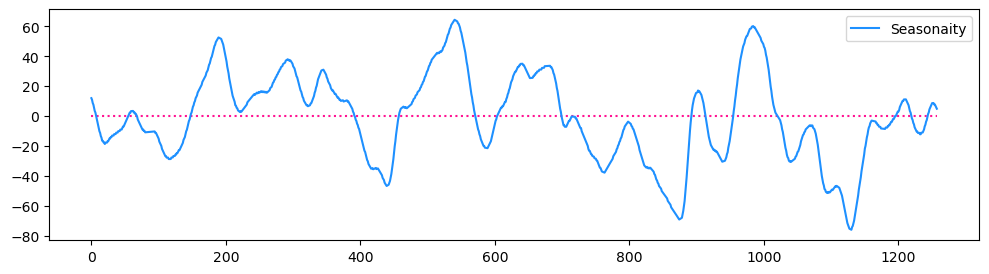

In [21]:
T = range( TimeSeries.shape[0] )
y = TimeSeries['Seasonality'] 

plt.figure(figsize=(12,3))
plt.plot([T[0],T[-1]],[0,0],color='deeppink', linestyle=':'        )
plt.plot(T,y,color='dodgerblue', linestyle='-', label='Seasonaity' )
plt.legend()
plt.show()

#####   
<span style="font-family:Arial; font-weight:Bold; font-size:2.3em; color:#00b3e5;"> ARIMA

In [22]:
from statsmodels.tsa.statespace.sarimax import SARIMAX   # Seasonal ARIMA

import warnings
warnings.filterwarnings('ignore')

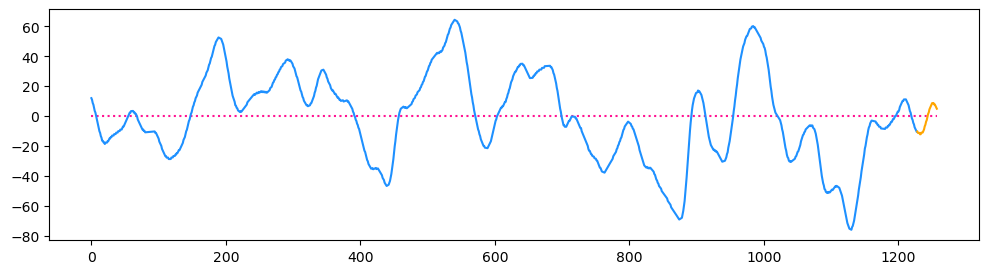

In [23]:
# input
n = 30   # n_Test

# Serie 
Series   = TimeSeries['Seasonality'].values.tolist()[:-n]
n_Series = len(Series)
T_Series = range(n_Series)

# Test
Test     = TimeSeries['Seasonality'].values.tolist()[-n:]
n_Test   = n
T_Test   = range( n_Series, n_Series+n_Test )

# Visualization
plt.figure(figsize=(12,3)); 
plt.plot( [T_Series[0],T_Test[-1]],[0,0], ":", color='deeppink' )
plt.plot( T_Series, Series, color='dodgerblue' )
plt.plot( T_Test  , Test  , color='orange'     )
plt.show()

In [24]:
from statsmodels.tsa.stattools import adfuller

print("\n\nAugmented Dickey-Fuller Unit Root Test") 
stat, p, lags, obs, crit, t = adfuller( Series )

print('stat=%.3f, p=%.3f' % (stat, p))
if p > 0.05: print('Time-Series is "Not Trend-Stationary"   (mean & variance  vary  over time)')
else: print('Time-Series is "Trend-Stationary"   (mean & variance  remain constant  over time)')



Augmented Dickey-Fuller Unit Root Test
stat=-3.267, p=0.016
Time-Series is "Trend-Stationary"   (mean & variance  remain constant  over time)


In [25]:
from statsmodels.tsa.stattools import kpss
print("\nKwiatkowski-Phillips-Schmidt-Shin Test")  
stat, p, lags, crit = kpss( Series )
print('stat=%.3f, p=%.3f' % (stat, p))
if p > 0.05: print('Time-Series is "Trend-Stationary"   (mean & variance  remain constant  over time)')
else: print('Time-Series is "Not Trend-Stationary"   (mean & variance  vary  over time)')


Kwiatkowski-Phillips-Schmidt-Shin Test
stat=0.708, p=0.013
Time-Series is "Not Trend-Stationary"   (mean & variance  vary  over time)


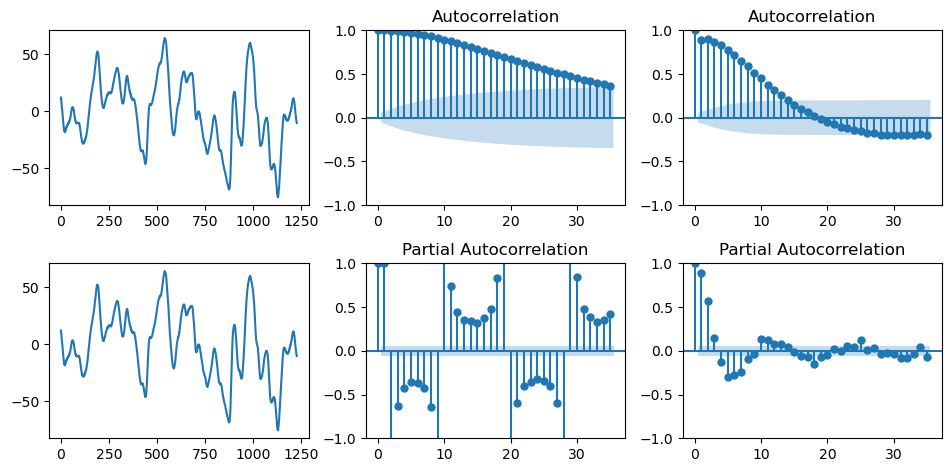

In [26]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
ts = pd.DataFrame(Series)
fig, axes = plt.subplots(2,3)
axes[0,0].plot(ts)
plot_acf( ts, lags=35, ax=axes[0,1] )
plot_acf( ts.diff().dropna(), lags=35, ax=axes[0,2] )
axes[1,0].plot(ts)
plot_pacf( ts, lags=35, ax=axes[1,1] )
plot_pacf( ts.diff().dropna(), lags=35, ax=axes[1,2] )
plt.tight_layout(pad=1, h_pad=None, w_pad=None, rect=(0, 0, 1.5, 1))

In [46]:
PDQs, RMSEs,AICs,BICs = [], [], [], []

n_pq = 15
for p in range(n_pq):
    for d in range(2):
        for q in range(n_pq):
            
            try:
                sarimax = SARIMAX(
                    endog                   =  Series,
                    order                   = (p,d,q),
                    seasonal_order          = (0, 0, 0, 0),
                    trend_offset            =  1,
                    trend                   =  None,   # None,'n','c','t','ct'
                    exog                    =  None,
                    dates                   =  None,
                    freq                    =  None,
                    mle_regression          =  True,
                    enforce_stationarity    =  True,
                    enforce_invertibility   =  True,
                    validate_specification  =  True,
                    time_varying_regression =  False,
                    hamilton_representation =  False, 
                    simple_differencing     =  False,
                    concentrate_scale       =  False,
                    measurement_error       =  False,
                    use_exact_diffuse       =  False,   
                    missing                 = 'none'
                    )
                model = sarimax.fit()
                
                print( 'p, d, q =', [p,d,q] )
         
                PRED    = [ x for x in model.forecast(steps=n_Test) ] 
                SE      = [ (i-j)**2 for i,j in zip(PRED,Test) ]
                RMSE    =   (np.sum(SE)/n_Test)**0.5
                RMSEs.append(np.round(RMSE,1))
                
                PDQs.append( (p,d,q) )
                AICs.append(int(np.round(model.aic,-1)))
                BICs.append(int(np.round(model.bic,-1)))
        
            except:
                continue

p, d, q = [0, 0, 0]
p, d, q = [0, 0, 1]
p, d, q = [0, 0, 2]
p, d, q = [0, 0, 3]
p, d, q = [0, 0, 4]
p, d, q = [0, 0, 5]
p, d, q = [0, 0, 6]
p, d, q = [0, 0, 7]
p, d, q = [0, 0, 8]
p, d, q = [0, 0, 9]
p, d, q = [0, 0, 10]
p, d, q = [0, 0, 11]
p, d, q = [0, 0, 12]
p, d, q = [0, 0, 13]
p, d, q = [0, 0, 14]
p, d, q = [0, 1, 0]
p, d, q = [0, 1, 1]
p, d, q = [0, 1, 2]
p, d, q = [0, 1, 3]
p, d, q = [0, 1, 4]
p, d, q = [0, 1, 5]
p, d, q = [0, 1, 6]
p, d, q = [0, 1, 7]
p, d, q = [0, 1, 8]
p, d, q = [0, 1, 9]
p, d, q = [0, 1, 10]
p, d, q = [0, 1, 11]
p, d, q = [0, 1, 12]
p, d, q = [0, 1, 13]
p, d, q = [0, 1, 14]
p, d, q = [1, 0, 0]
p, d, q = [1, 0, 1]
p, d, q = [1, 0, 2]
p, d, q = [1, 0, 3]
p, d, q = [1, 0, 4]
p, d, q = [1, 0, 5]
p, d, q = [1, 0, 6]
p, d, q = [1, 0, 7]
p, d, q = [1, 0, 8]
p, d, q = [1, 0, 9]
p, d, q = [1, 0, 10]
p, d, q = [1, 0, 11]
p, d, q = [1, 0, 12]
p, d, q = [1, 0, 13]
p, d, q = [1, 0, 14]
p, d, q = [1, 1, 0]
p, d, q = [1, 1, 1]
p, d, q = [1, 1, 2]
p, d, q = [1, 1, 3]
p, d,

p, d, q = [13, 0, 10]
p, d, q = [13, 0, 11]
p, d, q = [13, 0, 12]
p, d, q = [13, 0, 13]
p, d, q = [13, 0, 14]
p, d, q = [13, 1, 0]
p, d, q = [13, 1, 1]
p, d, q = [13, 1, 2]
p, d, q = [13, 1, 3]
p, d, q = [13, 1, 4]
p, d, q = [13, 1, 5]
p, d, q = [13, 1, 6]
p, d, q = [13, 1, 7]
p, d, q = [13, 1, 8]
p, d, q = [13, 1, 9]
p, d, q = [13, 1, 10]
p, d, q = [13, 1, 11]
p, d, q = [13, 1, 12]
p, d, q = [13, 1, 13]
p, d, q = [13, 1, 14]
p, d, q = [14, 0, 0]
p, d, q = [14, 0, 1]
p, d, q = [14, 0, 2]
p, d, q = [14, 0, 3]
p, d, q = [14, 0, 4]
p, d, q = [14, 0, 5]
p, d, q = [14, 0, 6]
p, d, q = [14, 0, 7]
p, d, q = [14, 0, 8]
p, d, q = [14, 0, 9]
p, d, q = [14, 0, 10]
p, d, q = [14, 0, 11]
p, d, q = [14, 0, 12]
p, d, q = [14, 0, 13]
p, d, q = [14, 0, 14]
p, d, q = [14, 1, 0]
p, d, q = [14, 1, 1]
p, d, q = [14, 1, 2]
p, d, q = [14, 1, 3]
p, d, q = [14, 1, 4]
p, d, q = [14, 1, 5]
p, d, q = [14, 1, 6]
p, d, q = [14, 1, 7]
p, d, q = [14, 1, 8]
p, d, q = [14, 1, 9]
p, d, q = [14, 1, 10]
p, d, q = [14, 1, 

In [27]:
df = pd.DataFrame( [RMSEs,PDQs,AICs,BICs] ).T
df.columns = ['rmse','( p, d, q )','aic','bic']
df.sort_values(['rmse','bic','aic'],ascending=[True,True,True],inplace=True)
df.head(10)

NameError: name 'RMSEs' is not defined

In [28]:
# SARIMAX
sarimax = SARIMAX(
    endog                   =  Series,
    order                   = (13,0,7),
    seasonal_order          = (0, 0, 0, 0),
    trend_offset            =  1,
    trend                   =  None,        # None,'n','c','t','ct'
    exog                    =  None,
    dates                   =  None,
    freq                    =  None,
    mle_regression          =  True,
    enforce_stationarity    =  True,
    enforce_invertibility   =  True,
    validate_specification  =  True,
    time_varying_regression =  False,
    hamilton_representation =  False, 
    simple_differencing     =  False,
    concentrate_scale       =  False,
    measurement_error       =  False,
    use_exact_diffuse       =  False,   
    missing                 = 'none'
)

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1228
Model:              SARIMAX(13, 0, 7)   Log Likelihood                -916.298
Date:                Sun, 03 Dec 2023   AIC                           1874.596
Time:                        23:24:28   BIC                           1981.972
Sample:                             0   HQIC                          1914.997
                               - 1228                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5807      0.301     -1.931      0.054      -1.170       0.009
ar.L2          0.0089      0.200      0.045      0.964      -0.383       0.401
ar.L3          1.1595      0.158      7.335      0.0

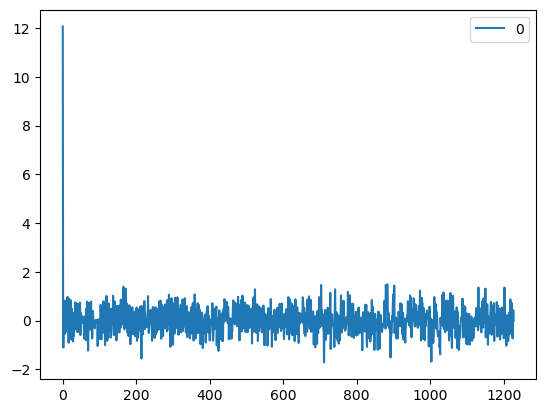

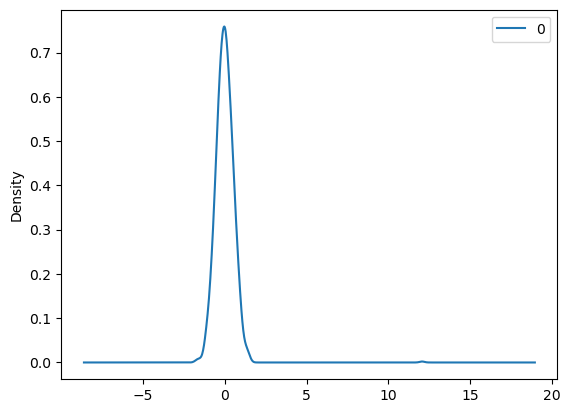

                 0
count  1228.000000
mean      0.006362
std       0.615029
min      -1.715835
25%      -0.338891
50%      -0.004813
75%       0.343079
max      12.068295


In [29]:
# fitted model
model = sarimax.fit()

# summary of fit model
print(model.summary())

# line plot of residuals
residuals = pd.DataFrame(model.resid)
residuals.plot()
plt.show()
# density plot of residuals
residuals.plot(kind='kde')
plt.show()

# summary stats of residuals
print(residuals.describe())

In [30]:
# forcasting  
PRED    = [ x for x in model.forecast(steps=n_Test) ] 
SE      = [ (i-j)**2 for i,j in zip(PRED,Test) ]
RMSE    =   (np.sum(SE)/n_Test)**0.5
RMSE

6.662572169722882

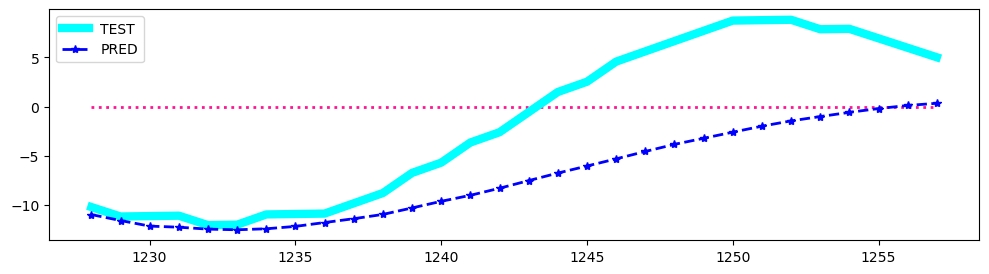

In [31]:
# visualizing
plt.figure( figsize=(12,3) )
plt.plot( [T_Test[0],T_Test[-1]], [0,0] ,  ":"  ,                color='deeppink' ,linewidth=2 )
plt.plot(        T_Test         , Test  ,  "-"  , label="TEST" , color='cyan'     ,linewidth=6 )
plt.plot(        T_Test         , PRED  , "--*" , label="PRED" , color='blue'     ,linewidth=2 )
plt.legend(); plt.show()

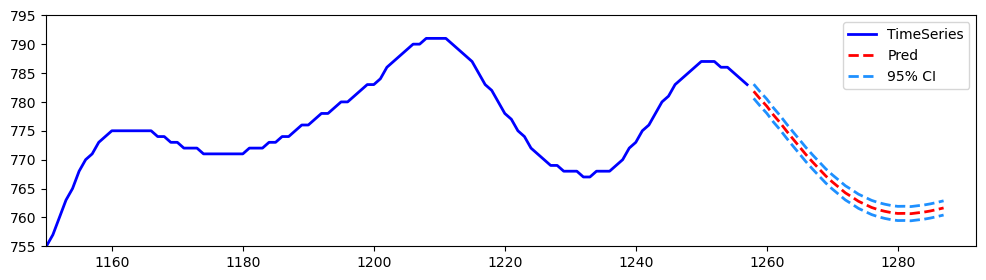

In [37]:
# input
p, q, d = 13, 0, 7
SD      = 0.615
n_Steps = n_Test 

# auto
TS = Series+Test
TS = [ x1+x2 for x1,x2 in zip( TS, TimeSeries['Cyclic_Trend'].values.tolist() )] 
n_TS =  len(    TS )
T_TS = range( n_TS )

model = SARIMAX(
    endog                   =  TS,
    order                   = (p,q,d),
    seasonal_order          = (0, 0, 0, 0),
    trend_offset            =  1,
    trend                   =  None,        # None,'n','c','t','ct'
    exog                    =  None,
    dates                   =  None,
    freq                    =  None,
    mle_regression          =  True,
    enforce_stationarity    =  True,
    enforce_invertibility   =  True,
    validate_specification  =  True,
    time_varying_regression =  False,
    hamilton_representation =  False, 
    simple_differencing     =  False,
    concentrate_scale       =  False,
    measurement_error       =  False,
    use_exact_diffuse       =  False,   
    missing                 = 'none'
).fit() 

# Forecasting Unknown Future
Pred        = [ x for x in model.forecast(steps=n_Steps) ]
T_Pred      = range( n_TS, n_TS+n_Steps )

# Confidence Interval
Pred_95_Top = [ x+2*SD for x in Pred ]
Pred_68_Top = [ x+1*SD for x in Pred ] 
Pred_68_Bot = [ x-1*SD for x in Pred ] 
Pred_95_Bot = [ x-2*SD for x in Pred ]  

# Visualizing
plt.figure( figsize=(12,3) )
plt.plot( [T_TS[0],T_Pred[-1]],   [0,0]    ,  ":" , color='deeppink'  , linewidth=2                     ) 
plt.plot(          T_TS       , TS ,  "-" , color='blue'      , linewidth=2, label="TimeSeries" )
plt.plot(          T_Pred             , Pred       , "--" , color='red'       , linewidth=2, label="Pred"       )
plt.plot(          T_Pred             , Pred_95_Top, "--" , color='dodgerblue', linewidth=2, label="95% CI"     )
#plt.plot(          T_Pred             , Pred_68_Top, "--" , color='lime'      , linewidth=2, label="68% CI"     )
#plt.plot(          T_Pred             , Pred_68_Bot, "--" , color='lime'      , linewidth=2                     )
plt.plot(          T_Pred             , Pred_95_Bot, "--" , color='dodgerblue', linewidth=2                     ) 
plt.xlim( 1150, T_Pred[-1]+5 )
plt.ylim([755,795])
plt.legend(); plt.show()

#####   
<span style="font-family:Arial; font-weight:Bold; font-size:2.3em; color:#00b3e5;"> Smoothed Series

In [22]:
# functions
# Time-Series Generator
def generate_time_series( bSize, nSteps ):  
    freq1, freq2, offsets1, offsets2 = np.random.rand(4, bSize, 1)
    time = np.linspace(0, 1, nSteps)
    series  = 0.5 * np.sin((time - offsets1) * (freq1 * 10 + 10))     #   wave 1
    series += 0.2 * np.sin((time - offsets2) * (freq2 * 20 + 20))     # + wave 2
    series += 0.1 * (np.random.rand(bSize, nSteps) - 0.5)             # + noise
    return series[..., np.newaxis].astype(np.float32)

# last_time_step_mse
def last_time_step_mse(Y_true, Y_pred):
    return keras.metrics.mean_squared_error(Y_true[:, -1], Y_pred[:, -1])

In [23]:
S = TimeSeries[['Smoothed_Series']].values.astype('float32') 
S = S[:,0]
S

array([325., 324., 322., ..., 785., 784., 783.], dtype=float32)

In [24]:
def under_under( S ): 
    A = [];
    for i in S:
        A.append([i])
    return A

A = under_under( S.copy() )  

In [25]:
# New_Series
import random as random

def New_Series( A ):
    New = A.copy()
    n = len(New)
    for i in range(n):  
        r = random.uniform(0.98,1.02)
        New[i][0] = New[i][0] * r
    return New   

B = New_Series( A )  
A = under_under( S ) 

In [26]:
N      = 30
nBatch = 1000  

Series = []
for i in range( nBatch+N ):
    A = under_under( S ) 
    Series.append( New_Series( A ) ) 
Series = np.array(Series) 

In [27]:
# (3) Best   WaveNet 
series = Series.copy()
bSize  = series.shape[0]
nSteps = series.shape[1]-N
n_neurons = max( [20,2*N] )

a, b = int(np.round(.7*bSize,0)), int(np.round(.9*bSize,0))

Y = np.empty(( bSize, nSteps, N ))  
for step_ahead in range( 1, N+1 ):
    Y[ : , : , step_ahead-1 ] = series[ : , step_ahead:step_ahead+nSteps, 0 ]

X_train, Y_train  =  series[  :a, :nSteps ],  Y[  :a ]
X_valid, Y_valid  =  series[ a:b, :nSteps ],  Y[ a:b ]
X_test,  Y_test   =  series[ b: , :nSteps ],  Y[ b:  ] 



model = keras.models.Sequential()

model.add( keras.layers.InputLayer(input_shape=[None, 1]) )

for rate in (1, 2, 4, 8) * 2:
    model.add( keras.layers.Conv1D( filters       =  n_neurons   # default is 20
                                  , kernel_size   =   2
                                  , padding       = "causal"
                                  , activation    = "relu"
                                  , dilation_rate =  rate
                                  ))

model.add( keras.layers.Conv1D(     filters       =  N   # default is 10
                                  , kernel_size   =  1    ))


print('Model Defined.')

Model Defined.


In [28]:
# load weights
version = 'BEST'
 
model.load_weights( Project_Name + '_' + version 
                  , by_name = False 
                  , skip_mismatch = False 
                  , options = None 
                  )

In [45]:
model.compile( loss      = "mse"
             , optimizer = "adam"     # 'sgd' 'adam' 'nadam' 'adamax'
             , metrics   = [last_time_step_mse]
             )
history = model.fit( X_train, Y_train
                   , epochs          =  20
                   , validation_data = (X_valid, Y_valid)
                   )

Epoch 1/20
23/23 [==============================] - 20s 766ms/step - loss: 4900.6167 - last_time_step_mse: 9070.7266 - val_loss: 2064.1990 - val_last_time_step_mse: 1776.0087
Epoch 2/20
23/23 [==============================] - 17s 764ms/step - loss: 900.0693 - last_time_step_mse: 1105.6565 - val_loss: 613.8344 - val_last_time_step_mse: 149.5191
Epoch 3/20
23/23 [==============================] - 17s 759ms/step - loss: 546.6650 - last_time_step_mse: 373.1574 - val_loss: 521.7518 - val_last_time_step_mse: 220.6901
Epoch 4/20
23/23 [==============================] - 17s 749ms/step - loss: 507.4941 - last_time_step_mse: 348.4839 - val_loss: 504.1731 - val_last_time_step_mse: 384.5304
Epoch 5/20
23/23 [==============================] - 17s 750ms/step - loss: 501.2675 - last_time_step_mse: 365.4634 - val_loss: 500.6348 - val_last_time_step_mse: 337.1367
Epoch 6/20
23/23 [==============================] - 17s 760ms/step - loss: 497.1143 - last_time_step_mse: 361.8307 - val_loss: 495.3615 - va

In [47]:
Y_pred = model.predict(X_test)   
MSE = np.mean( keras.losses.mean_squared_error( Y_test, Y_pred ) ) 
print('\nRMSE =',np.round(MSE**.5,4))

4/4 [==============================] - 1s 154ms/step

RMSE = 21.4593


In [48]:
# save weights
version = '03'

model.save_weights( Project_Name + '_' + version
                  , overwrite = True 
                  , save_format = None 
                  , options = None 
                  )

In [49]:
# load weights
version = '03'
 
model.load_weights( Project_Name + '_' + version 
                  , by_name = False 
                  , skip_mismatch = False 
                  , options = None 
                  )

In [50]:
A = np.array([ under_under(  S  ) ])   # either (the same)
#A = np.array([ under_under( S[N:] ) ])   #   or   (the same)

Y_preds = model.predict( A ) 
Preds = np.round( Y_preds[-1][-1],0 )

1/1 [==============================] - 1s 517ms/step


In [51]:

df_Preds = pd.DataFrame()
df_Preds['Preds'] = Preds

def smoother( df, ft, n ):
    s = df[ft].values.copy()
    for i in range(n): 
        for i in np.arange( 2, df.shape[0]-1, 2 ):
            s[i] = ( s[i-1]+s[i+1] ) / 2
        for i in np.arange( 1, df.shape[0]-1, 2 ):
            s[i] = ( s[i-1]+s[i+1] ) / 2
    noise = df[ft].values.copy() - s
    return s, noise

Smoothed_Preds, Noise = smoother( df_Preds, 'Preds', 3 )
Smoothed_Preds = np.round( Smoothed_Preds, 0 ) 
Smoothed_Preds# Smoothing Predictions

array([782., 781., 780., 780., 779., 778., 778., 778., 778., 779., 779.,
       779., 779., 779., 779., 779., 779., 780., 780., 780., 781., 781.,
       781., 782., 782., 782., 783., 783., 784., 784.], dtype=float32)

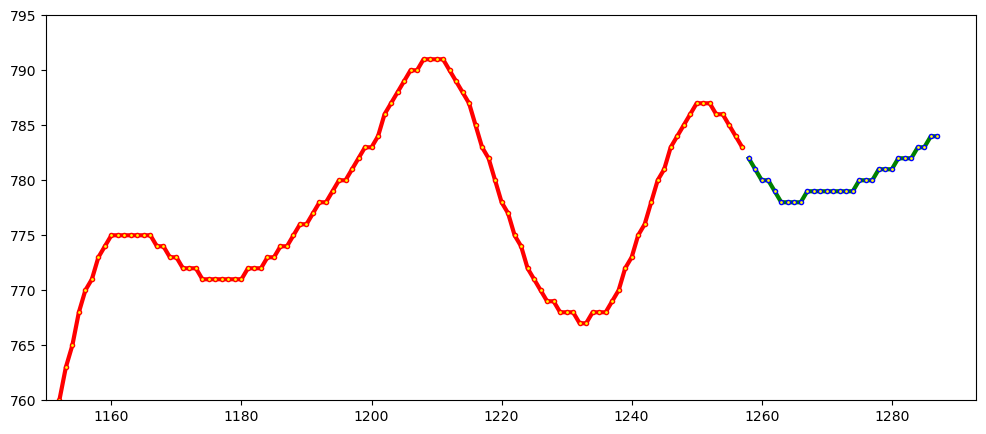

In [54]:
fig, ax = plt.subplots(figsize=(12,5))

ax.plot(  range(len(S)), S
        , lw=3, c='r', ls='-'
        , marker='o', markersize=3
        , mec='red' , mew=1, mfc='yellow')

ax.plot(  np.arange(len(S),len(S)+N), Smoothed_Preds
        , lw=3, c='g', ls='-'
        , marker='o', markersize=3
        , mec='blue', mew=1, mfc='yellow' )
#plt.xlim([-20,len(S)+N+20])
#plt.ylim([0,1300])
plt.xlim([1150,len(S)+N+5])
plt.ylim([760,795])

plt.savefig( Project_Name+'_Version_'+version+'_.png', dpi=120 )
plt.show()

#####   

#####   

In [53]:
## save weights
#version = 'BEST'    # RMSE = 21.6
#model.save_weights( Project_Name+'_'+version, overwrite=True, save_format=None, options=None )

#####   